## 1. Data Exploration and Preprocessing

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ppscore 1.3.0 requires pandas<2.0.0,>=1.0.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load dataset
df = pd.read_csv("/content/adult_with_headers.csv")

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Check for missing values
missing_counts = df.isna().sum()
print("Missing Values:\n", missing_counts[missing_counts > 0])

# Data info and summary
df.info()
print("\nSummary Statistics:")
print(df.describe(include='all'))

# Feature scaling
numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Standard Scaling
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numerical_cols] = standard_scaler.fit_transform(df[numerical_cols])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numerical_cols] = minmax_scaler.fit_transform(df[numerical_cols])

# Previews
print("\nStandard Scaled Preview:\n", df_standard_scaled[numerical_cols].head())
print("\nMin-Max Scaled Preview:\n", df_minmax_scaled[numerical_cols].head())

Missing Values:
 Series([], dtype: int64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

Summary Statistics:
                 age workclass

## 2. Encoding Techniques

In [3]:
from sklearn.preprocessing import LabelEncoder

# One-Hot Encoding: For categories with <5 unique values
one_hot_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() < 5]
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Label Encoding: For other categorical columns
label_cols = [col for col in df.select_dtypes(include='object').columns if col not in one_hot_cols]
label_encoder = LabelEncoder()
for col in label_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

print("Encoded Data Preview:")
print(df_encoded.head())

Encoded Data Preview:
   age  workclass  fnlwgt  education  education_num  marital_status  \
0   39          7   77516          9             13               4   
1   50          6   83311          9             13               2   
2   38          4  215646         11              9               0   
3   53          4  234721          1              7               2   
4   28          4  338409          9             13               2   

   occupation  relationship  race  capital_gain  capital_loss  hours_per_week  \
0           1             1     4          2174             0              40   
1           4             0     4             0             0              13   
2           6             1     4             0             0              40   
3           6             0     2             0             0              40   
4          10             5     2             0             0              40   

   native_country  sex_ Female  sex_ Male  income_ <=50K  income

### Encoding Pros & Cons

- **One-Hot Encoding**
  - No ordinal assumptions
  - Increases dimensionality

- **Label Encoding**
  - Compact
  - Implies order (can mislead models like linear regression)

##  3. Feature Engineering

In [4]:
import numpy as np

# Feature 1: Is Capital Active
df_encoded['capital_active'] = (df['capital_gain'].astype(float) > 0) | (df['capital_loss'].astype(float) > 0)

# Feature 2: Age Bucket
df_encoded['age_bucket'] = pd.cut(df['age'].astype(int), bins=[0, 25, 45, 65, 100], labels=['Young', 'Mid-Age', 'Senior', 'Elder'])

# Log transform skewed capital_gain
df_encoded['log_capital_gain'] = df['capital_gain'].astype(float).apply(lambda x: np.log1p(x))

print("Engineered Features Preview:")
print(df_encoded[['capital_active', 'age_bucket', 'log_capital_gain']].head())

Engineered Features Preview:
   capital_active age_bucket  log_capital_gain
0            True    Mid-Age          7.684784
1           False     Senior          0.000000
2           False    Mid-Age          0.000000
3           False     Senior          0.000000
4           False    Mid-Age          0.000000


### Rationale

- **Capital Active**: Binary indicator of financial activity.
- **Age Bucket**: Converts continuous age into interpretable categories.
- **Log Capital Gain**: Reduces skew for more balanced learning.

##  4. Feature Selection

Rows after removing outliers: 32235


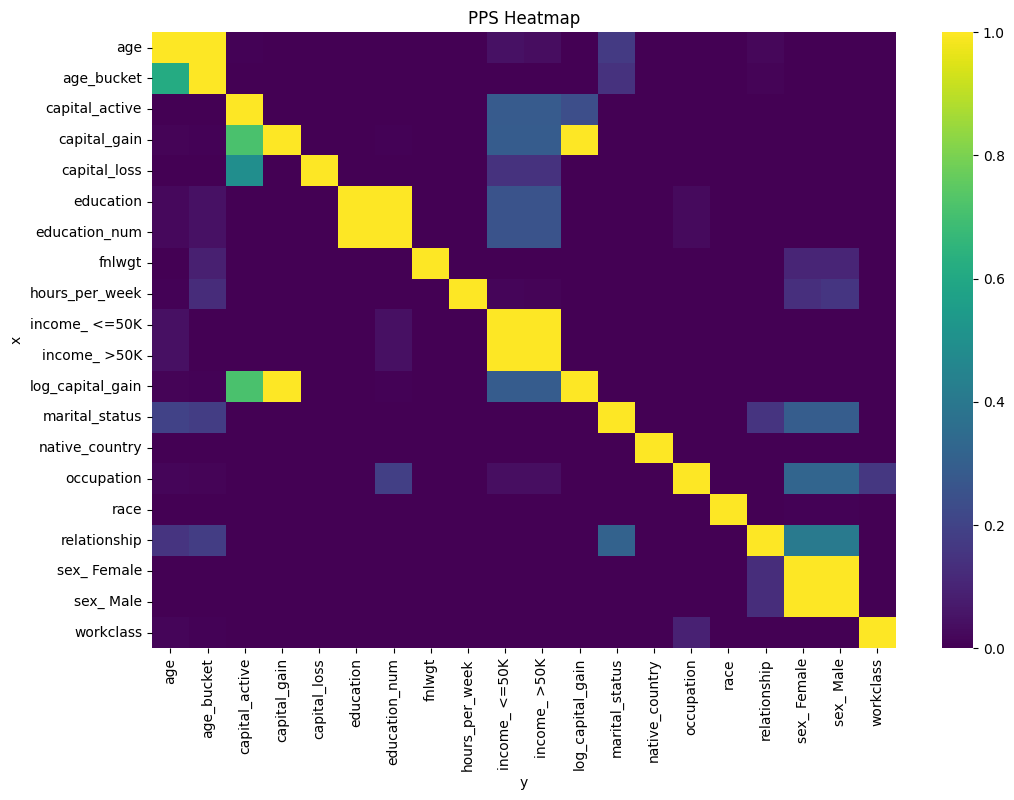

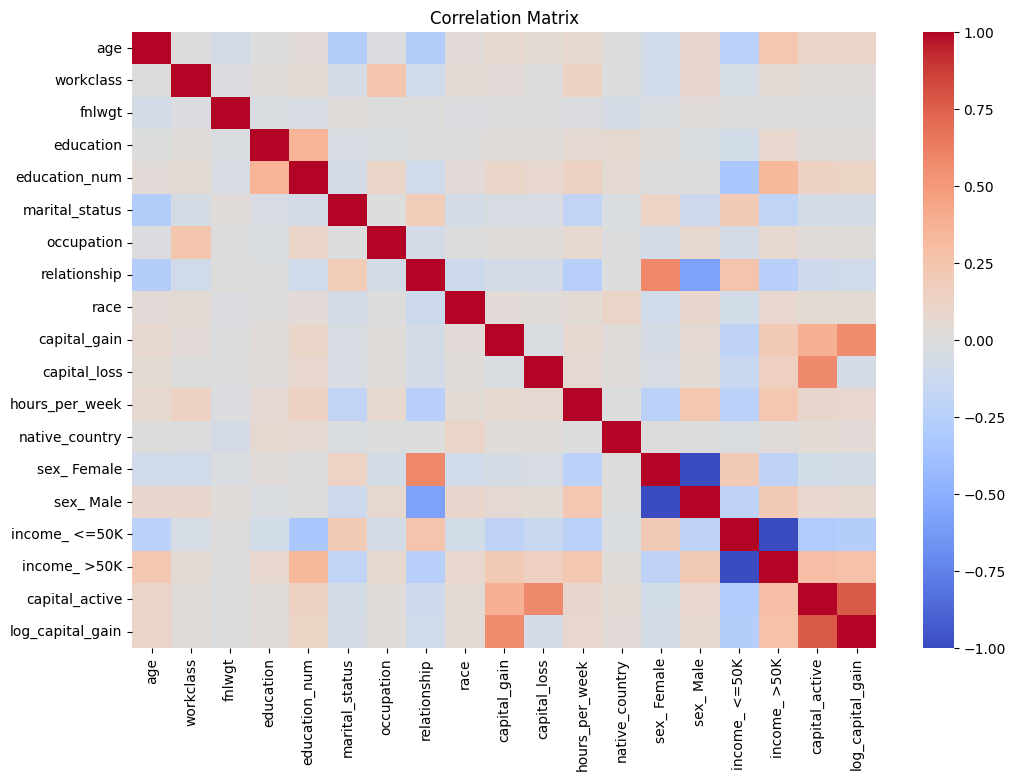

In [5]:
from sklearn.ensemble import IsolationForest
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_encoded.select_dtypes(include=[np.number]))
df_clean = df_encoded[outliers == 1]

print(f"Rows after removing outliers: {df_clean.shape[0]}")

# Predictive Power Score (PPS)
pps_matrix = pps.matrix(df_clean)
pps_heatmap = pps_matrix.pivot(index='x', columns='y', values='ppscore')

# Plot PPS heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pps_heatmap, cmap="viridis", annot=False)
plt.title("PPS Heatmap")
plt.show()

# Correlation heatmap for comparison
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

### Outlier & Feature Analysis

- **Isolation Forest** removed ~1% of anomalous rows to reduce noise.
- **PPS** identifies predictive relationships (nonlinear & asymmetric).
- Compared PPS with traditional correlation for deeper insight.